In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skfeature.function.information_theoretical_based import MRMR

pd.set_option('display.max_columns', None)

In [2]:
signal = pd.read_csv("signal.csv", sep = ";")
bkg = pd.read_csv("background.csv", sep = ";")


In [3]:
signal = signal.drop(signal.filter(regex='MC').columns, axis=1)
signal = signal.drop(signal.filter(regex='Weight').columns, axis=1)
signal = signal.drop(signal.filter(regex='Corsika').columns, axis=1)
signal = signal.drop(signal.filter(regex='end').columns, axis=1)
signal = signal.drop(signal.filter(regex='start').columns, axis=1)
signal = signal.drop(signal.filter(regex='time').columns, axis=1)
signal = signal.drop('label', axis=1)

In [4]:
bkg = bkg.drop(bkg.filter(regex='MC').columns, axis=1)
bkg = bkg.drop(bkg.filter(regex='Weight').columns, axis=1)
bkg = bkg.drop(bkg.filter(regex='Corsika').columns, axis=1)
bkg = bkg.drop(bkg.filter(regex='end').columns, axis=1)
bkg = bkg.drop(bkg.filter(regex='start').columns, axis=1)
bkg = bkg.drop(bkg.filter(regex='time').columns, axis=1)
bkg = bkg.drop('label', axis=1)

In [5]:
signal.replace([np.inf, -np.inf], np.nan)
signal.dropna(axis = 'columns', inplace = True)
signal = signal.drop(signal.std()[(signal.std() == 0)].index, axis=1)
#signal.dropna(inplace = True)

bkg.replace([np.inf, -np.inf], np.nan)
bkg.dropna(axis = 'columns', inplace = True)
bkg = bkg.drop(bkg.std()[(bkg.std() == 0)].index, axis=1)
#bkg.dropna(inplace = True)

In [6]:
bcol = bkg.columns
scol = signal.columns

In [7]:
for att in scol:
    if att not in bcol:
        signal.drop(att, axis=1, inplace = True)
    
for att in bcol:
    if att not in scol:
        bkg.drop(att, axis=1, inplace = True)

In [8]:
len(signal.columns)

118

In [9]:
len(bkg.columns)

118

In [10]:
#removed_scol = [j for i, j in zip(signal.columns, bkg.columns) if i != j]
#removed_scol

In [11]:
import scipy.io
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn import svm

In [12]:
sig_label = np.zeros(signal.shape[0])
bkg_label = np.ones(bkg.shape[0])

In [13]:
combined_df = pd.concat([signal, bkg], ignore_index=True)
combined_label = np.append(sig_label, bkg_label)

In [14]:
combined_df.insert(118, 'label', combined_label)
shuffled = combined_df.sample(frac = 1)

In [15]:
y = shuffled['label']
X = shuffled.drop('label', axis=1)

In [16]:
from sklearn import (
    ensemble, linear_model, neighbors, svm, tree, naive_bayes,
    gaussian_process, neural_network, dummy)
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from tqdm import tqdm
model = ensemble.RandomForestClassifier(n_estimators=100)
model.get_params()
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n_trees = [1, 5, 10, 50, 100]
for i in n_trees:
    Sc = cross_val_score(ensemble.RandomForestClassifier(n_estimators= i), X_train, y_train, cv=5, scoring='roc_auc')
    print(Sc)

[0.95796538 0.9637487  0.96265348 0.96906122 0.95953687]
[0.9989289  0.99957261 0.99888388 0.99928691 0.99983359]
[0.99998599 0.99988369 0.99999121 0.99998936 0.9998853 ]
[0.99999316 0.99998247 0.99999321 0.99999619 0.99999146]
[0.99999668 0.99999971 0.99999951 0.99999897 0.99999922]


In [19]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
# Anzahl der features die wir nehmen wollen
N_feat = 60
X_new = SelectKBest(score_func=f_classif, k=N_feat)
d_fit = X_new.fit(X_train, y_train)
# generiere scores die die güte des features angeben
scores = d_fit.scores_
# sortiere nach größe...
sorted_scores = sorted(scores, reverse=True)
args_max = np.argsort(scores)[::-1]
# print(args_max)
# lese die N_feat wichtigsten features aus und speichere sie weg
features = []
for i in range(N_feat):
    features.append(X.columns.tolist()[args_max[i]])
print(features)
# werfe aus den trainingsdaten und testdaten alle features bis auf die wichtigsten raus
X_train = X_train.loc[:, features]
X_test = X_test.loc[:, features]

['LineFit_TTParams.lf_vel_z', 'I3EventHeader.Run', 'I3EventHeader.Event', 'HitStatisticsValues.z_travel', 'LineFit_TT.zenith', 'SplineMPEFitParams.rlogl', 'MuEXAngular4.zenith', 'SplineMPEMuEXDifferential.zenith', 'SplineMPETruncatedEnergy_SPICEMie_AllBINS_Muon.zenith', 'SplineMPE.zenith', 'SplineMPETruncatedEnergy_SPICEMie_AllDOMS_Muon.zenith', 'MPEFitHighNoise.zenith', 'MPEFitParaboloid.zenith', 'MPEFitParaboloidFitParams.zenith', 'SplineMPEDirectHitsA.n_dir_strings', 'SplineMPEDirectHitsA.n_dir_doms', 'SplineMPEDirectHitsC.dir_track_length', 'SplineMPETruncatedEnergy_SPICEMie_AllDOMS_MuEres.value', 'SplineMPEDirectHitsC.n_dir_doms', 'HitStatisticsValues.cog_z_sigma', 'HitStatisticsValues.z_sigma', 'HitStatisticsValues.z_min', 'NewAtt.DirectEllipse', 'SPEFit2Bayesian.z', 'SplineMPEDirectHitsE.dir_track_length', 'NewAtt.SplineVerRadius', 'NewAtt.radius', 'SplineMPECharacteristics.track_hits_separation_length', 'SplineMPETruncatedEnergy_SPICEMie_AllBINS_MuEres.value', 'MuEXAngular4_Sig

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score, roc_auc_score, roc_curve
# trainiere den lerner
model.fit(X_train, y_train)
# sage die labels vorher
y_pred = model.predict(X_test)
fpr, tpr, thr = roc_curve(y_test, y_pred)

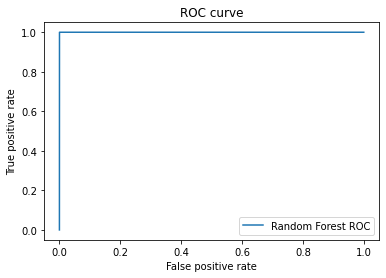

In [21]:
plt.figure(1)
plt.plot(fpr, tpr, label='Random Forest ROC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [22]:
print(roc_auc_score(y_test, y_pred))
print(r2_score(y_test, y_pred))
# das kann nicht sein

0.9998759612999255
0.9994999699669461


In [ ]:
#cv = KFold(5, shuffle=True, random_state=42)

#models = []
#predictions = []
#true_values = []

#n_feat = 10

#for train_index, test_index in cv.split(df):
#    X_train, X_test = df.iloc[train_index, :], df.iloc[test_index, :]
#    y_train, y_test = y[train_index], y[test_index]
#    
#    model.fit(X_train, y_train)
#    pred = model.predict(X_test)
#    t_val = y_test
    
#    predictions.append(pred)
#    true_values.append(t_val)
#    models.append(model)

In [ ]:
#predictions

In [ ]:

#for i in range(5):
#    r2 = r2_score(true_values[i], predictions[i])
#    roc = roc_auc_score(true_values[i], predictions[i])
#    print("r2 score: \n", r2)
#    print("roc auc score: \n", roc)